<a href="https://colab.research.google.com/github/Mdasiftalukdar/Medical-Image-Classification-Employing-DCGAN-and-CNN-Transfer-Learning-Techniques/blob/main/DCGAN_on_Chest_X_ray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import pandas as pd 
import random
import tensorflow as tf

# folder
import os
import glob


import cv2
import seaborn as sns
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, SeparableConv2D, MaxPooling2D, Lambda
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose, Conv2D, add, concatenate
from tensorflow.keras.layers import LeakyReLU, Activation, Reshape
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau

# image
from PIL import Image

# visu
import matplotlib.pyplot as plt
plt.rc('image', cmap='gray')

# sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#tensorflow
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
categories = ["NORMAL", "PNEUMONIA"]
datasets = ["train", "test", "val"]

In [ ]:
widths = []
heights = []


for set_ in datasets:
    for cat in categories:
        filelist = glob.glob('/content/drive/MyDrive/Colab Notebooks/datasets/Chest X-Ray Images (Pneumonia)/chest_xray/' + set_ + '/' + cat + '/*.jpeg')
        print(set_ + '/' + cat + '/')
        for fname in filelist:
            widths.append(Image.open(fname).size[0])
            heights.append(Image.open(fname).size[1])
        

images_size = pd.DataFrame({"widths": widths, "heights": heights})

        
print("Average image width: " + f'{images_size["widths"].mean():.2f}')
print("Average image height: " + f'{images_size["heights"].mean():.2f}')

In [ ]:
image_width=64
image_height=64

In [ ]:

data = []
target = []

for set_ in datasets:
    for cat in categories:
        print(set_ + '/' + cat + '/')
        filelist = glob.glob('/content/drive/MyDrive/Colab Notebooks/datasets/Chest X-Ray Images (Pneumonia)/chest_xray/' + set_ + '/' + cat + '/*.jpeg')
        target.extend([cat for _ in filelist])
        data.extend([np.array(Image.open(fname).convert('L').resize((64, 64))) for fname in filelist])


train/NORMAL/
train/PNEUMONIA/
test/NORMAL/
test/PNEUMONIA/
val/NORMAL/
val/PNEUMONIA/


In [ ]:
data_array = np.stack(data, axis=0)
data_array.shape

(5856, 64, 64)

In [ ]:
print(np.array(target).shape)

(5856,)


In [ ]:
#fake normal image added

filelist = glob.glob('/content/drive/MyDrive/Colab Notebooks/datasets/Chest X-Ray Images (Pneumonia)/testing/*.png')
data.extend([np.array(Image.open(fname).convert('L').resize((64, 64))) for fname in filelist])
target.extend(['NORMAL' for _ in filelist])
print(np.array(data).shape)


(5966, 64, 64)


In [ ]:
data_array = np.stack(data, axis=0)
data_array.shape

(5966, 64, 64)

In [ ]:
print(np.array(target).shape)

(5966,)


In [ ]:
pd.concat([pd.DataFrame(pd.DataFrame({"target" : target}).value_counts()).rename(columns={0:"count"}),
           pd.DataFrame(pd.DataFrame(target).value_counts()*100/len(target)).applymap(round).rename(columns={0:"%"})], axis=1)

count   %
target              
PNEUMONIA   4273  72
NORMAL      1693  28

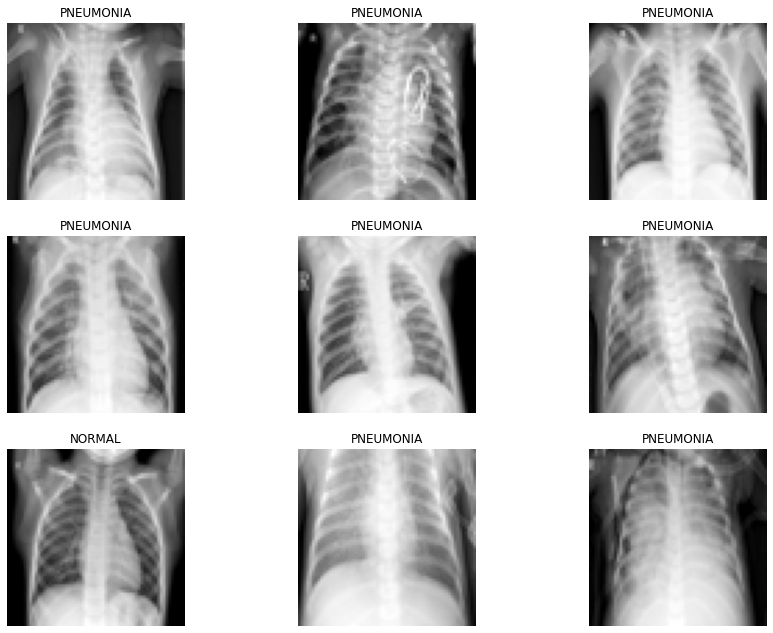

In [ ]:
fig = plt.figure(figsize=(20,15))
gs = fig.add_gridspec(4, 4)
#
for line in range(0, 3):
    for row in range(0, 3):
        num_image = random.randint(0, data_array.shape[0])
        ax = fig.add_subplot(gs[line, row])
        ax.axis('off');
        ax.set_title(target[num_image])
        ax.imshow(data_array[num_image]);

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_array, np.array(target), random_state=43, test_size=0.2, stratify=target)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4772, 64, 64)
(1194, 64, 64)
(4772,)
(1194,)


In [ ]:
pd.DataFrame(y_train).value_counts()/len(y_train)

PNEUMONIA    0.716262
NORMAL       0.283738
dtype: float64

In [ ]:
pd.DataFrame(y_test).value_counts()/len(y_test)

PNEUMONIA    0.71608
NORMAL       0.28392
dtype: float64

In [ ]:
print(X_train.max())
print(X_train.min())

255
0


In [ ]:
X_test_norm = np.round((X_test/255), 3).copy()
X_train_norm = np.round((X_train/255), 3).copy()

In [ ]:
print(X_train_norm.max())
print(X_train_norm.min())

1.0
0.0


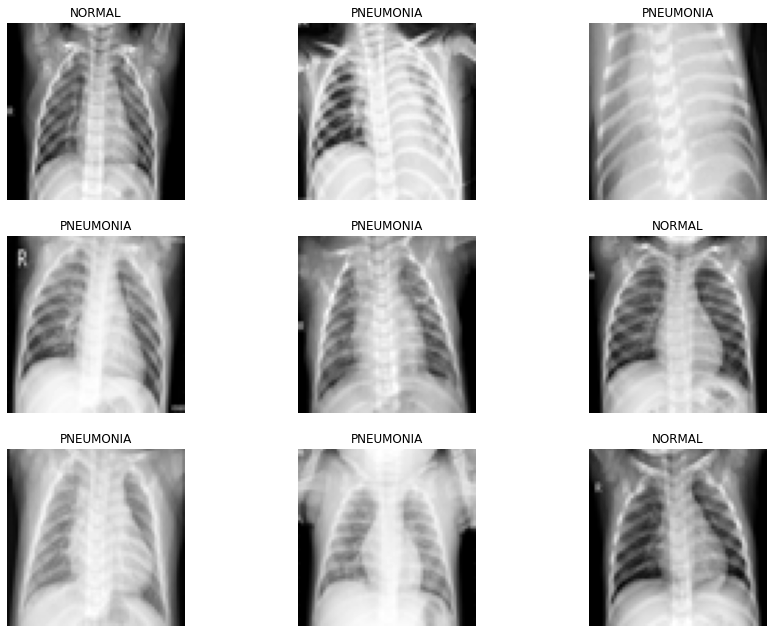

In [ ]:
fig = plt.figure(figsize=(20,15))
gs = fig.add_gridspec(4, 4)
#
for line in range(0, 3):
    for row in range(0, 3):
        num_image = random.randint(0, X_train_norm.shape[0])
        ax = fig.add_subplot(gs[line, row])
        ax.axis('off');
        ax.set_title(y_train[num_image])
        ax.imshow(X_train_norm[num_image]);

In [ ]:
y_train

array(['NORMAL', 'NORMAL', 'PNEUMONIA', ..., 'PNEUMONIA', 'PNEUMONIA',
       'NORMAL'], dtype='<U9')

In [ ]:
encoder = LabelEncoder().fit(y_train)

In [ ]:
y_train_cat = encoder.transform(y_train)
y_test_cat = encoder.transform(y_test)

In [ ]:
y_train_cat

array([0, 0, 1, ..., 1, 1, 0])

In [ ]:
X_train_norm.shape

(4772, 64, 64)

In [ ]:
X_train_cnn = X_train_norm.reshape(-1, 64, 64, 1)
X_test_cnn = X_test_norm.reshape(-1, 64, 64, 1)
X_train_cnn.shape

(4772, 64, 64, 1)

In [ ]:
X_test_cnn.shape

(1194, 64, 64, 1)

## **testing cnn with fake data included**

In [ ]:
def initialize_model():
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=(image_height, image_width, 1), padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation="relu", padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation="relu", padding='same'))
    model.add(layers.MaxPool2D(pool_size=(3, 3)))
    model.add(layers.Flatten())
    model.add(layers.Dense(120, activation='relu'))
    model.add(layers.Dense(60, activation='relu'))
    model.add(layers.Dropout(rate=0.2))
    model.add(layers.Dense(1, activation='sigmoid'))

    return model
model = initialize_model()
def compile_model(model):
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics="accuracy")
    return model

In [ ]:
model = initialize_model()
model = compile_model(model)
es = EarlyStopping(patience=15, monitor='val_accuracy', restore_best_weights=True)

history = model.fit(X_train_cnn, y_train_cat,
                    batch_size=8,
                    epochs=20,
                    validation_split=0.3,
                    callbacks=[es])

Epoch 1/20
418/418 [==============================] - 5s 11ms/step - loss: 0.3606 - accuracy: 0.8395 - val_loss: 0.2116 - val_accuracy: 0.9295
Epoch 2/20
418/418 [==============================] - 4s 10ms/step - loss: 0.2014 - accuracy: 0.9231 - val_loss: 0.2092 - val_accuracy: 0.9232
Epoch 3/20
418/418 [==============================] - 4s 10ms/step - loss: 0.1587 - accuracy: 0.9395 - val_loss: 0.1521 - val_accuracy: 0.9392
Epoch 4/20
418/418 [==============================] - 4s 10ms/step - loss: 0.1425 - accuracy: 0.9461 - val_loss: 0.1556 - val_accuracy: 0.9427
Epoch 5/20
418/418 [==============================] - 4s 10ms/step - loss: 0.1275 - accuracy: 0.9488 - val_loss: 0.1236 - val_accuracy: 0.9504
Epoch 6/20
418/418 [==============================] - 4s 10ms/step - loss: 0.1155 - accuracy: 0.9554 - val_loss: 0.2060 - val_accuracy: 0.9225
Epoch 7/20
418/418 [==============================] - 4s 10ms/step - loss: 0.1041 - accuracy: 0.9614 - val_loss: 0.1311 - val_accuracy: 0.9511

In [ ]:
model.evaluate(X_test_cnn, y_test_cat, verbose=1)

38/38 [==============================] - 1s 9ms/step - loss: 0.2025 - accuracy: 0.9447


[0.20249749720096588, 0.9447236061096191]

# **CNN**

In [ ]:
def initialize_model():
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=(image_height, image_width, 1), padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation="relu", padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation="relu", padding='same'))
    model.add(layers.MaxPool2D(pool_size=(3, 3)))
    model.add(layers.Flatten())
    model.add(layers.Dense(120, activation='relu'))
    model.add(layers.Dense(60, activation='relu'))
    model.add(layers.Dropout(rate=0.2))
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [ ]:
model = initialize_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 5, 5, 128)        0

In [ ]:
def compile_model(model):
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics="accuracy")
    return model

In [ ]:
model = initialize_model()
model = compile_model(model)
es = EarlyStopping(patience=15, monitor='val_accuracy', restore_best_weights=True)

history = model.fit(X_train_cnn, y_train_cat,
                    batch_size=8,
                    epochs=20,
                    validation_split=0.3,
                    callbacks=[es])

Epoch 1/20
410/410 [==============================] - 35s 83ms/step - loss: 0.3327 - accuracy: 0.8682 - val_loss: 0.1696 - val_accuracy: 0.9395
Epoch 2/20
410/410 [==============================] - 34s 82ms/step - loss: 0.1755 - accuracy: 0.9375 - val_loss: 0.2112 - val_accuracy: 0.9175
Epoch 3/20
410/410 [==============================] - 34s 82ms/step - loss: 0.1356 - accuracy: 0.9521 - val_loss: 0.1359 - val_accuracy: 0.9495
Epoch 4/20
410/410 [==============================] - 34s 83ms/step - loss: 0.1221 - accuracy: 0.9567 - val_loss: 0.1498 - val_accuracy: 0.9431
Epoch 5/20
410/410 [==============================] - 34s 82ms/step - loss: 0.1093 - accuracy: 0.9613 - val_loss: 0.1362 - val_accuracy: 0.9488
Epoch 6/20
410/410 [==============================] - 34s 82ms/step - loss: 0.0917 - accuracy: 0.9652 - val_loss: 0.1415 - val_accuracy: 0.9481
Epoch 7/20
410/410 [==============================] - 34s 83ms/step - loss: 0.0909 - accuracy: 0.9683 - val_loss: 0.1311 - val_accuracy:

In [ ]:
model.evaluate(X_test_cnn, y_test_cat, verbose=1)

37/37 [==============================] - 3s 68ms/step - loss: 0.2216 - accuracy: 0.9437


[0.22161047160625458, 0.9436860084533691]

In [ ]:
X_test_cnn.shape

(1172, 64, 64, 1)

# **GAN**

In [ ]:
X_train_gan = np.repeat(X_train_norm[..., np.newaxis], 3, -1)
X_train_gan.shape

In [ ]:
X_test_gan = np.repeat(X_test_norm[..., np.newaxis], 3, -1)
X_test_gan.shape

### **GAN discriminator**

In [ ]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)            

## **generator**

In [ ]:
latent_dim = 100

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              827392    
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 256)      524544    
 ranspose)                                                       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 256)       0 

In [ ]:

dataset_normal = keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Colab Notebooks/datasets/Chest X-Ray Images (Pneumonia)/chest_xray/train/PNEUMONIA", label_mode=None, image_size=(64, 64), batch_size=32
)



Found 3875 files belonging to 1 classes.


In [ ]:
for data in dataset_normal.take(1):
    print(data.shape)

(32, 64, 64, 3)


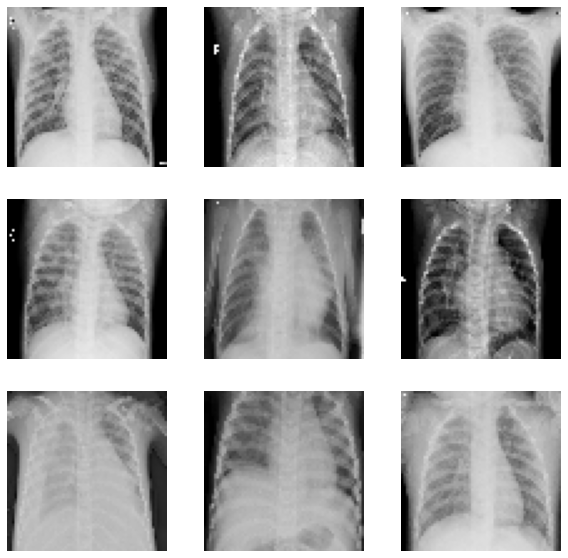

In [ ]:
import matplotlib.pyplot as plt
 
class_names = dataset_normal.class_names
plt.figure(figsize=(10, 10))
for images in dataset_normal.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        #plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
dataset_normal = dataset_normal.map(lambda x: x / 255.0)

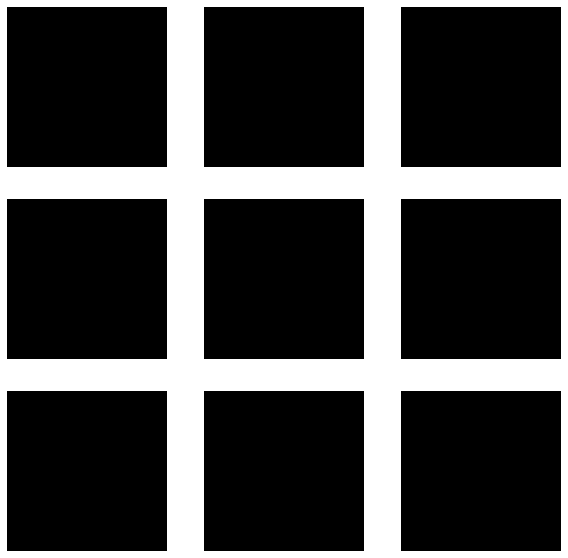

In [ ]:
import matplotlib.pyplot as plt
 

plt.figure(figsize=(10, 10))
for images in dataset_normal.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        #plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
type(dataset_normal)

tensorflow.python.data.ops.dataset_ops.MapDataset

## **GAN class**

In [ ]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

### **Create a callback that periodically saves generated images**

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("/content/drive/MyDrive/Colab Notebooks/datasets/Chest X-Ray Images (Pneumonia)/generated images pneumonia/generated_img_%03d_%d.png" % (epoch+1, i+1))
            
            
            # print(type(img))
            # savePath = '/content/drive/MyDrive/Colab Notebooks/datasets/Chest X-Ray Images (Pneumonia)/generated image'
            # with open(savePath, "wt") as f:
            #   f.write(img)
            # #img = np.array(img)
            
            
            
            # os.makedirs(os.path.dirname(txt_filepath), exist_ok=True)
            # with open(txt_filepath, "wt") as f:
            #   f.write(text)
            #img.save("generated_img_%03d_%d.png" % (epoch, i))
            #images_dir = '/content/drive/MyDrive/Colab Notebooks/datasets/Chest X-Ray Images (Pneumonia)/chest_xray/test/generated image'
            #plt.savefig(f"{images_dir}/abc.png")
            #plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
            #plt.show()

## **Train the end-to-end model**

In [ ]:
epochs = 200  # In practice, use ~100 epochs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset_normal, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

Epoch 1/200
122/122 [==============================] - 371s 3s/step - d_loss: 0.3188 - g_loss: 1.2955
Epoch 2/200
122/122 [==============================] - 77s 624ms/step - d_loss: -0.2300 - g_loss: 27.1845
Epoch 3/200
122/122 [==============================] - 78s 632ms/step - d_loss: 0.1064 - g_loss: 21.0520
Epoch 4/200
122/122 [==============================] - 78s 630ms/step - d_loss: 0.7979 - g_loss: 5.8685
Epoch 5/200
122/122 [==============================] - 78s 632ms/step - d_loss: 0.2172 - g_loss: 4.7069
Epoch 6/200
122/122 [==============================] - 78s 631ms/step - d_loss: 0.4270 - g_loss: 3.3283
Epoch 7/200
122/122 [==============================] - 78s 631ms/step - d_loss: 0.4131 - g_loss: 1.7684
Epoch 8/200
122/122 [==============================] - 78s 631ms/step - d_loss: 0.6029 - g_loss: 1.3629
Epoch 9/200
122/122 [==============================] - 78s 632ms/step - d_loss: 0.7016 - g_loss: 1.1906
Epoch 10/200
122/122 [==============================] - 78s 631

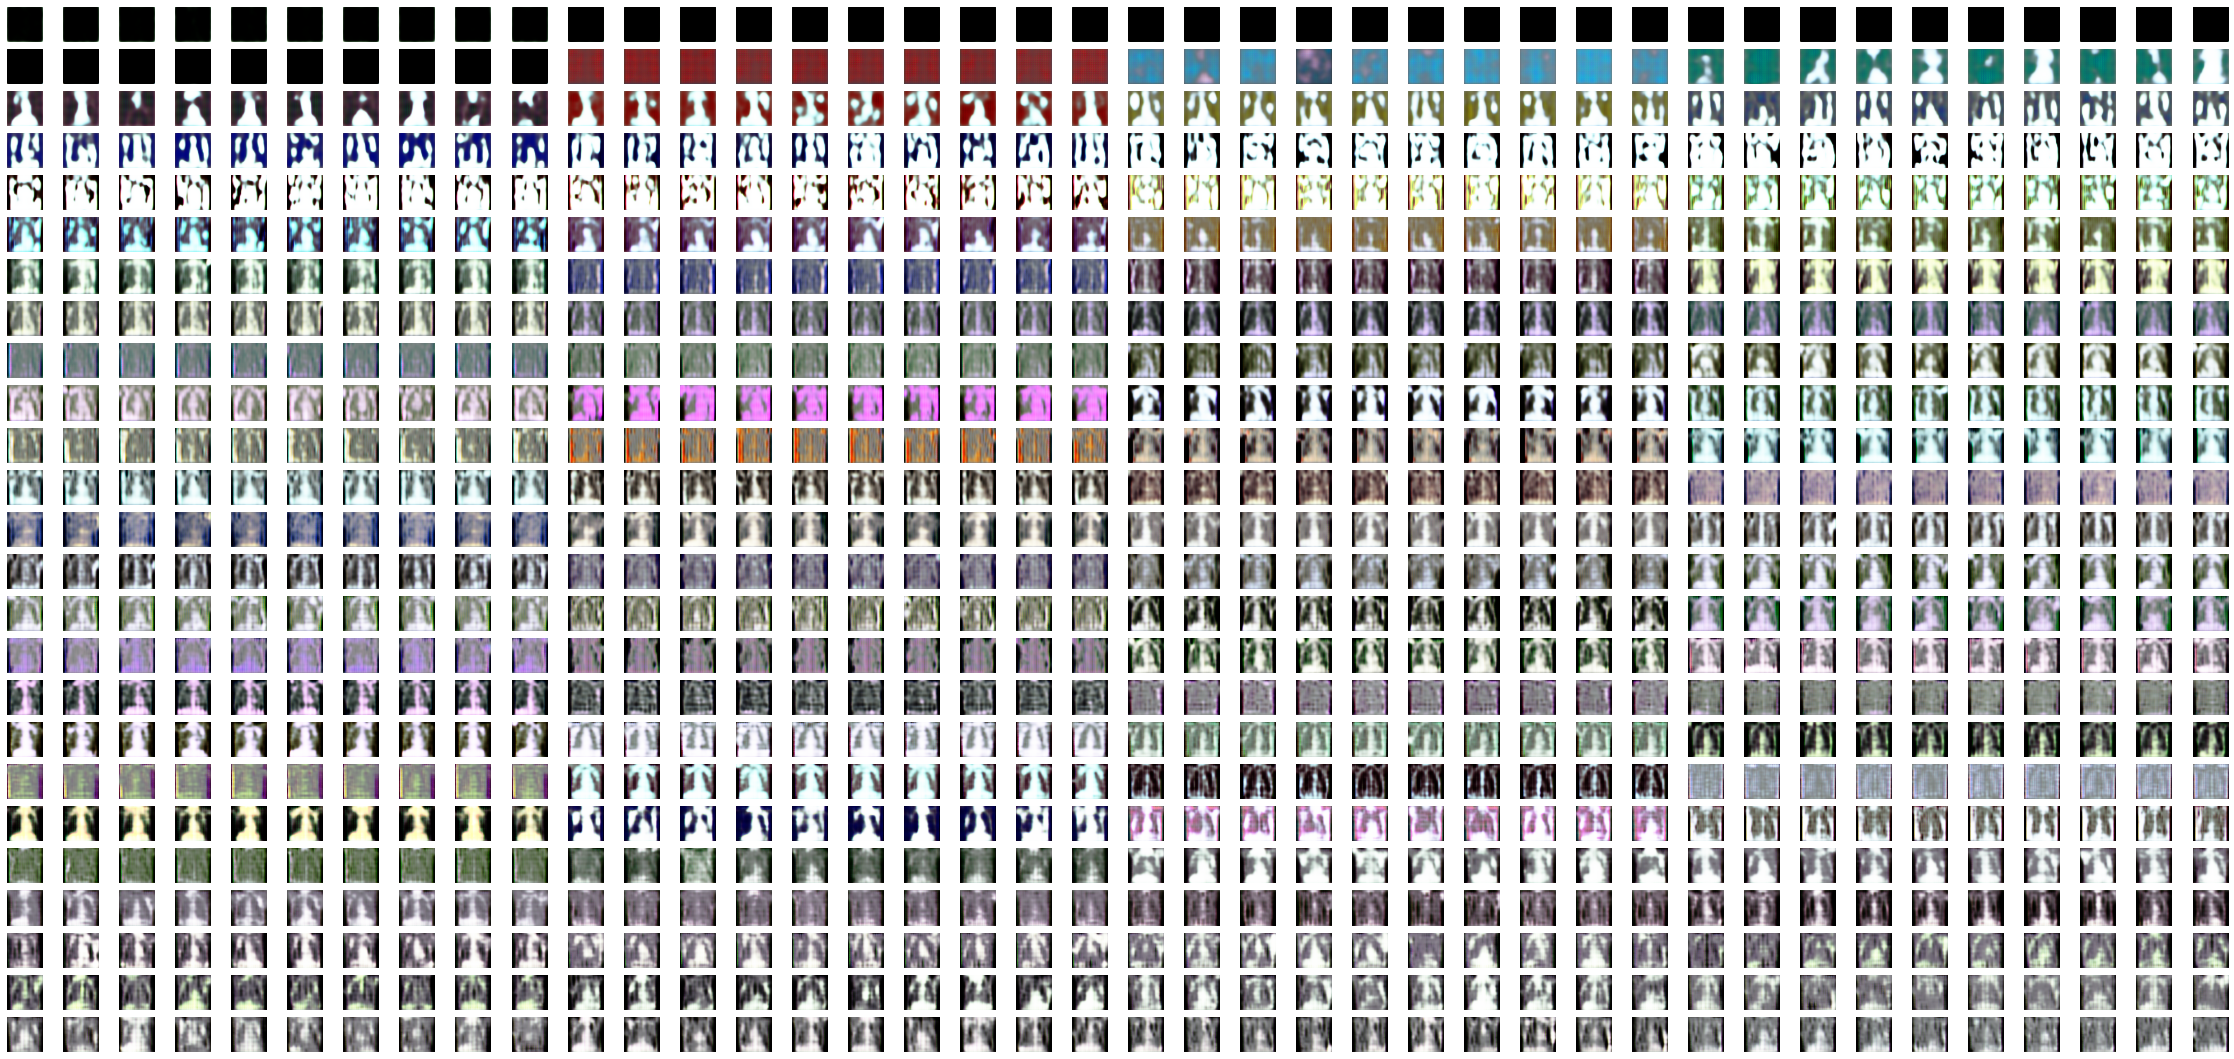

In [ ]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

images = []
for img_path in glob.glob('/content/drive/MyDrive/Colab Notebooks/datasets/Chest X-Ray Images (Pneumonia)/generated images/*.png'):
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(40,20))
columns = 40
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.axis('off')
    #fig.tight_layout() 
    plt.imshow(image)